# AirBnB Washington DC Project
## Part i: Understanding the what customer cares through their reviews

## Data set: InsideAirBnB - Washington D.C.
### Lok Tin Kevin Chan

AirBnB is a platform economy that facilitate digital interactions between real estate owners and customers for short to mid-term stay. The aim of the project is to explore AirBnB's in Washington DC and gain a better understanding:

    1) What do users care about during their AirBnB Stay?
    2) What factors affect listing price of an AirBnB listing?

This first part of the project aims to look at the reviews left by customers and try to gain an understanding what factors do customer care in choosing airbnb listings.

The <a href = http://insideairbnb.com/get-the-data.html>dataset</a> is collected through webscrapping publicly avaliable information on AirBnB website. As of the date analysis the data is updated to from 2015 to Septmber 2019.


In [47]:
# Importing libraries
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import geopandas as geopd
import seaborn as sns
import datetime as dt
import re
import numpy as np
import pandas as pd
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
import pylab as pl
import calendar


from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from langdetect import detect
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [56]:
# import dataset [Review.csv] for data cleaning and eda
df_review = pd.read_csv("../0_Data/reviews.csv", encoding='utf-8')

# Looking at the summary stats for dataset
df_review.describe().T

# There is 358,268 comments in total 

,count,mean,std,min,25%,50%,75%,max
listing_id,358268.0,1.419388e+07,8.835870e+06,3344.0,6779201.0,14552591.0,2.051582e+07,38727301.0
id,358268.0,2.705202e+08,1.484804e+08,588.0,145857048.0,262623342.5,4.175024e+08,534611186.0
reviewer_id,358268.0,8.258116e+07,7.259999e+07,3.0,22260309.0,60201465.0,1.293950e+08,296182794.0


Metadata information

Listing_id: Unique Id for the listing

id: Review/Comment Id

date: Date of review

reviewier_id: Unqiue Id for the reviewer

reviewier_name: first name of the reviewer

Comments: Review

In [51]:
#Data simple data Cleaning

# Convert Date  from string to date time object

df_review['date'] = pd.to_datetime(df_review['date'])

# Checking missing values

df_review.isnull().sum() 

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         178
dtype: int64

In [52]:
# as only a small amount compared to total reviews, dropping reviews with null comments 

df_review.dropna(inplace=True)

In [53]:
# Create data set of count of review at each date 
df_date_r = pd.DataFrame(df_review.groupby('date')['comments'].count())

df_date = df_date_r.reset_index()


# add new columns for Year, Month, Day, and day of week
#Year
df_date['Year'] = df_date['date'].dt.year

#Month
df_date['Month'] = df_date['date'].dt.month

#Day
df_date['Day'] = df_date['date'].dt.day

#Weekday
df_date['Day of Week'] = df_date['date'].dt.dayofweek

# reorganise column order
df_date = df_date[['date','Year','Month','Day','Day of Week','comments']]

df_date.set_index('date',inplace=True)

df_date.head()



,Year,Month,Day,Day of Week,comments
date,,,,,
2009-01-21,2009,1,21,2,3
2009-01-22,2009,1,22,3,1
2009-03-26,2009,3,26,3,2
2009-04-07,2009,4,7,1,1
2009-05-09,2009,5,9,5,1


In [57]:
pandas_profiling.ProfileReport(df_review)

## Reviews
### Distribution of reviews

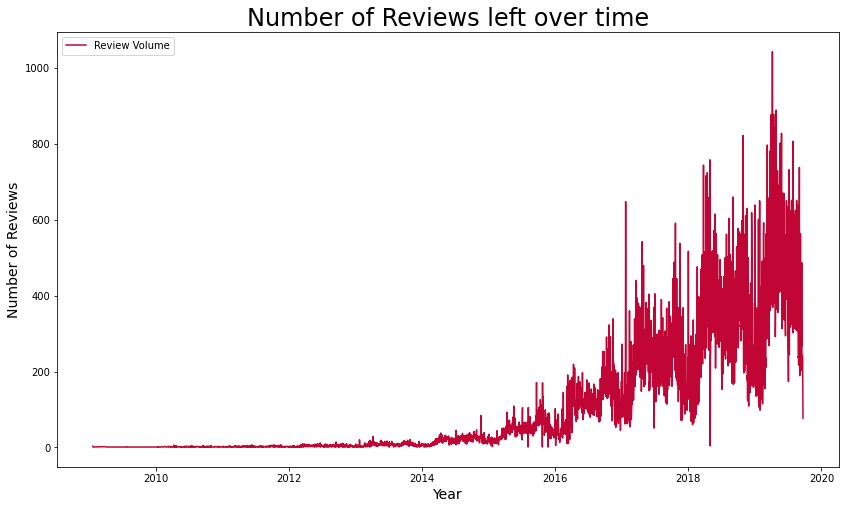

In [11]:
#EDA

#Configure the viewing area
plt.figure(figsize=(14, 8))

#Creating the plot
plt.plot(df_date['comments'], color='#c10534', zorder=0)
plt.xlabel('Year', fontdict={'fontsize': 14})
plt.ylabel('Number of Reviews', fontdict={'fontsize': 14})
plt.title('Number of Reviews left over time', fontdict={'fontsize': 24})
plt.legend(['Review Volume', 'Daily Average']);

From the above chart, it is well observed that the number of comments left steady increased over the years. This can be explained with the increase popularity of AirBnB over the past decade and the increase in the number of the listing posting in Washington DC. Though, we can observe fluctuations of the number of reviews left during a single year. 

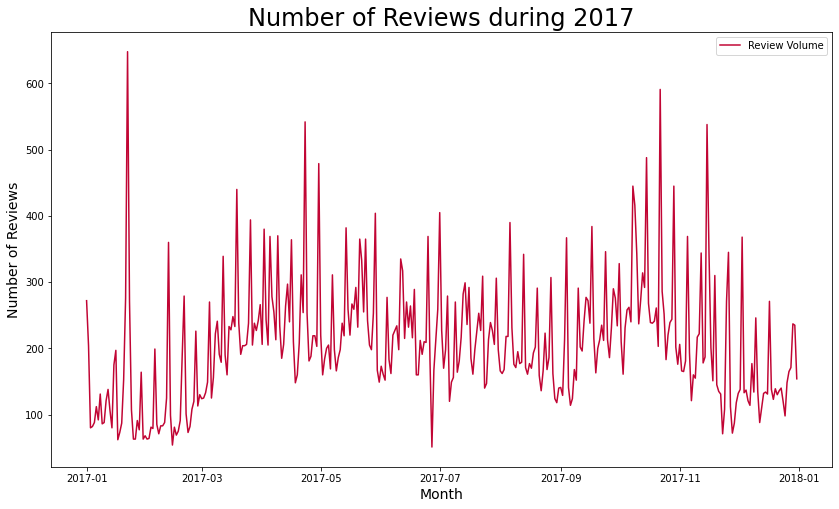

In [25]:
# Configure the plot viewing area
plt.figure(figsize=(14, 8))

#Create the plot
plt.plot(df_date[df_date['Year'] == 2017]['comments'], color='#c10534', zorder=0)
plt.xlabel('Month', fontdict={'fontsize': 14})
plt.ylabel('Number of Reviews', fontdict={'fontsize': 14})
plt.title('Number of Reviews during 2017', fontdict={'fontsize': 24})
plt.legend(['Review Volume', 'Daily Average']);

Taking a sample within a year - 2017, we can observe reviews spikes and drops throughout the years. For example, Feb 2017 was an exceptionally warm February which cause a strong spike in tourist visiting DC. Another example are events such as April - May 2017 - Cherry Blossom period in DC.   

In [53]:
pd.DataFrame(df_date.groupby('Month')['comments'].count())

,comments
Month,
1,269
2,235
3,285
4,285
5,296
6,289
7,294
8,292
9,280


In [54]:
pd.DataFrame(df_date.groupby('Day of Week')['comments'].count())

,comments
Day of Week,
0,476
1,467
2,473
3,472
4,485
5,469
6,472


Though on average over the year each month or day of the week has pretty even distribution of number of reviews. 

### Topic Modeling - LDA

Though the contents of the reviews are much more interesting. To better understanding what peoplare interested, we conduct Topic modeling with LDA to cluster word groups and similar expressions that best characterize the reviews.

In [33]:
#Topic modeling

# Convert df_review Comments into a list string
data = df_review.comments.values.tolist()

# Obtain stop words 
stop_words = stopwords.words('english')
stop_words.extend(['great', 'good', 'recommend', 'also', 'would', 'definitely', 'get', 'away', 'time','greatly','highly'])

In [34]:
# Process the tokenize the sentence and removing the punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Peak at the tokenized sentence
print(data_words[:1])

[['the', 'stay', 'at', 'amos', 'condo', 'greatly', 'exceeded', 'my', 'expectations', 'this', 'is', 'great', 'location', 'that', 'is', 'short', 'walk', 'from', 'two', 'metro', 'stations', 'and', 'is', 'surrounded', 'by', 'business', 'offices', 'other', 'condos', 'and', 'restaurants', 'very', 'clean', 'and', 'neat', 'accommodations', 'bed', 'was', 'small', 'cot', 'style', 'bed', 'with', 'foam', 'mattress', 'that', 'was', 'adequate', 'had', 'exclusive', 'use', 'of', 'bathroom', 'with', 'shower', 'including', 'space', 'to', 'keep', 'my', 'shower', 'supplies', 'amos', 'went', 'above', 'and', 'beyond', 'to', 'make', 'me', 'feel', 'welcome', 'in', 'his', 'home', 'not', 'only', 'did', 'he', 'pick', 'me', 'up', 'from', 'the', 'airport', 'but', 'he', 'dropped', 'me', 'off', 'when', 'my', 'stay', 'was', 'finished', 'highly', 'recommend', 'that', 'anyone', 'planning', 'trip', 'to', 'dc', 'stay', 'with', 'amos', 'you', 'won', 'regret', 'it', 'amos', 'had', 'stocked', 'the', 'kitchen', 'with', 'plen

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'stay', 'at', 'amos', 'condo', 'greatly', 'exceeded', 'my', 'expectations', 'this', 'is', 'great', 'location', 'that', 'is', 'short', 'walk', 'from', 'two', 'metro', 'stations', 'and', 'is', 'surrounded', 'by', 'business', 'offices', 'other', 'condos', 'and', 'restaurants', 'very', 'clean', 'and', 'neat', 'accommodations', 'bed', 'was', 'small', 'cot', 'style', 'bed', 'with', 'foam_mattress', 'that', 'was', 'adequate', 'had', 'exclusive', 'use', 'of', 'bathroom', 'with', 'shower', 'including', 'space', 'to', 'keep', 'my', 'shower', 'supplies', 'amos', 'went', 'above', 'and', 'beyond', 'to', 'make', 'me', 'feel', 'welcome', 'in', 'his', 'home', 'not', 'only', 'did', 'he', 'pick', 'me', 'up', 'from', 'the', 'airport', 'but', 'he', 'dropped', 'me', 'off', 'when', 'my', 'stay', 'was', 'finished', 'highly', 'recommend', 'that', 'anyone', 'planning', 'trip', 'to', 'dc', 'stay', 'with', 'amos', 'you', 'won_regret', 'it', 'amos', 'had', 'stocked', 'the', 'kitchen', 'with', 'plenty', 't

In [36]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stay', 'exceed', 'expectation', 'location', 'short', 'walk', 'metro', 'station', 'surround', 'business', 'office', 'condo', 'restaurant', 'clean', 'neat', 'accommodation', 'bed', 'small', 'cot', 'style', 'bed', 'adequate', 'exclusive', 'use', 'bathroom', 'shower', 'include', 'space', 'keep', 'shower', 'supply', 'go', 'make', 'feel', 'welcome', 'home', 'pick', 'airport', 'drop', 'stay', 'finish', 'plan', 'trip', 'stay', 'stock', 'kitchen', 'plenty', 'eat', 'breakfast', 'access', 'appliance', 'choose']]


In [37]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('access', 1),
  ('accommodation', 1),
  ('adequate', 1),
  ('airport', 1),
  ('appliance', 1),
  ('bathroom', 1),
  ('bed', 2),
  ('breakfast', 1),
  ('business', 1),
  ('choose', 1),
  ('clean', 1),
  ('condo', 1),
  ('cot', 1),
  ('drop', 1),
  ('eat', 1),
  ('exceed', 1),
  ('exclusive', 1),
  ('expectation', 1),
  ('feel', 1),
  ('finish', 1),
  ('go', 1),
  ('home', 1),
  ('include', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('location', 1),
  ('make', 1),
  ('metro', 1),
  ('neat', 1),
  ('office', 1),
  ('pick', 1),
  ('plan', 1),
  ('plenty', 1),
  ('restaurant', 1),
  ('short', 1),
  ('shower', 2),
  ('small', 1),
  ('space', 1),
  ('station', 1),
  ('stay', 3),
  ('stock', 1),
  ('style', 1),
  ('supply', 1),
  ('surround', 1),
  ('trip', 1),
  ('use', 1),
  ('walk', 1),
  ('welcome', 1)]]

In [10]:
# Build LDA model and sets initial parameters
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.286*"quick" + 0.100*"response" + 0.091*"way" + 0.080*"ask" + 0.069*"ride" '
  '+ 0.057*"drive" + 0.044*"show" + 0.038*"request" + 0.031*"drink" + '
  '0.027*"personal"'),
 (1,
  '0.142*"highly" + 0.114*"helpful" + 0.113*"responsive" + 0.082*"spacious" + '
  '0.081*"accommodate" + 0.065*"extremely" + 0.063*"fantastic" + '
  '0.062*"coffee" + 0.039*"recommend" + 0.035*"describe"'),
 (2,
  '0.127*"apartment" + 0.110*"walk" + 0.062*"parking" + 0.045*"kitchen" + '
  '0.044*"minute" + 0.039*"street" + 0.037*"use" + 0.034*"station" + '
  '0.031*"take" + 0.026*"metro"'),
 (3,
  '0.150*"clean" + 0.084*"nice" + 0.072*"space" + 0.052*"close" + 0.049*"room" '
  '+ 0.047*"really" + 0.040*"bed" + 0.029*"quiet" + 0.026*"lot" + '
  '0.025*"house"'),
 (4,
  '0.093*"cool" + 0.080*"option" + 0.065*"walking" + 0.062*"week" + '
  '0.059*"pleasant" + 0.057*"tourist" + 0.051*"several" + 0.050*"care" + '
  '0.043*"ton" + 0.042*"hospitable"'),
 (5,
  '0.307*"restaurant" + 0.157*"distance" + 0.098*"ba

To evaluate the model, we calculate the perplexity and coherence score. The perplexity score indicates how well a model predicts a sample of text where the lower the score indicates a better generalization score. 

While Coherence score is used to assess the quality of the learned topics.

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.701579679768226

Coherence Score:  0.5667303076340477


In [28]:
# We repeat the above model with various number of topic to search for the optimal number of topics to search for the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [95]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=18, step=2)

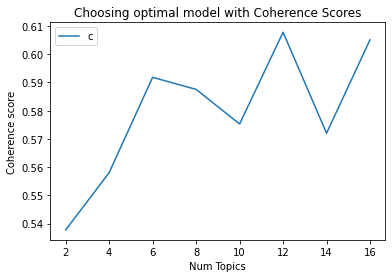

<Figure size 432x288 with 0 Axes>

In [97]:
# Create graph for coherence score for different number of topics
limit=18; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Choosing optimal model with Coherence Scores")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('../3_Figures/Modelselectoin_Coherence.png')

In [38]:
# Compute LDA Model with 6 topics
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
pprint(lda_model2.print_topics())
doc_lda = lda_model2[corpus]

[(0,
  '0.049*"small" + 0.037*"response" + 0.036*"arrival" + 0.036*"day" + '
  '0.034*"shower" + 0.027*"water" + 0.025*"hot" + 0.025*"property" + '
  '0.024*"reservation" + 0.023*"fast"'),
 (1,
  '0.063*"room" + 0.052*"bed" + 0.046*"parking" + 0.033*"kitchen" + '
  '0.031*"bathroom" + 0.027*"little" + 0.025*"stylish" + 0.022*"bedroom" + '
  '0.017*"expect" + 0.016*"private"'),
 (2,
  '0.036*"home" + 0.032*"make" + 0.025*"beautiful" + 0.023*"feel" + '
  '0.021*"thank" + 0.021*"love" + 0.021*"go" + 0.021*"enjoy" + '
  '0.020*"wonderful" + 0.019*"back"'),
 (3,
  '0.078*"stay" + 0.073*"place" + 0.051*"clean" + 0.047*"location" + '
  '0.044*"host" + 0.029*"nice" + 0.024*"space" + 0.024*"apartment" + '
  '0.024*"comfortable" + 0.021*"walk"'),
 (4,
  '0.066*"spot" + 0.046*"issue" + 0.041*"enough" + 0.032*"food" + 0.025*"list" '
  '+ 0.023*"option" + 0.023*"mall" + 0.021*"future" + 0.018*"build" + '
  '0.018*"kid"'),
 (5,
  '0.023*"night" + 0.021*"could" + 0.021*"communication" + 0.019*"use" +

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -6.6002207167894245

Coherence Score:  0.5941688827695634


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.375530 -0.019255       1        1  42.629832
2     -0.131430  0.300607       2        1  21.920946
5      0.160593  0.091785       3        1  15.792204
1     -0.104212 -0.322790       4        1  11.116896
4     -0.114439 -0.153703       5        1   4.594472
0     -0.186043  0.103357       6        1   3.945650, topic_info=           Term           Freq          Total Category  logprob  loglift
39         stay  211661.000000  211661.000000  Default  30.0000  30.0000
101       place  196555.000000  196555.000000  Default  29.0000  29.0000
10        clean  137301.000000  137301.000000  Default  28.0000  28.0000
25     location  128270.000000  128270.000000  Default  27.0000  27.0000
79         host  117864.000000  117864.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
1127  complaint    2362.503163    2363.484093   Topic6  -4.6648   3.2321
645    accurate    2325.151934    2326.131733   Topic6  -4.6807   3.2321
15       exceed    2266.627894    2267.606732   Topic6  -4.7062   3.2321
1209         do    2213.902779    2214.885523   Topic6  -4.7297   3.2321
231         day    9079.401812   25337.187276   Topic6  -3.3185   2.2063

[214 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1         5  0.999662  accommodation
645       6  0.999513       accurate
514       6  0.999802         almost
233       1  0.999966        amazing
847       1  0.999938        amenity
...     ...       ...            ...
130       6  0.999898          water
493       4  0.999837        weekend
131       1  0.999976           well
229       2  0.999956      wonderful
133       3  0.999964           work

[186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 2, 5, 1])

In [44]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model2, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4039,"stay, place, clean, location, host, nice, spac...","[stay, exceed, expectation, location, short, w..."
1,1,5.0,0.3603,"night, could, communication, use, find, work, ...","[say, pick, wait, patiently, hour, clear, cust..."
2,2,5.0,0.3069,"night, could, communication, use, find, work, ...","[host, start, first, pay, cab, ride, beautiful..."
3,3,3.0,0.5474,"stay, place, clean, location, host, nice, spac...","[host, excellent, location, clean, neat, house..."
4,4,3.0,0.3535,"stay, place, clean, location, host, nice, spac...","[first, com, user, host, intelligent, gracious..."
5,5,3.0,0.4805,"stay, place, clean, location, host, nice, spac...","[host, pick, arrival, bring, airport, departur..."
6,6,3.0,0.4408,"stay, place, clean, location, host, nice, spac...","[excellent, host, make, trip, pleasant, experi..."
7,7,3.0,0.4770,"stay, place, clean, location, host, nice, spac...","[hospitable, accommodate, apartment, nicely, f..."
8,8,3.0,0.4353,"stay, place, clean, location, host, nice, spac...","[host, accommodation, spotless, comfortable, c..."
9,9,3.0,0.4225,"stay, place, clean, location, host, nice, spac...","[host, cancel, reservation, day, arrival]"


In [45]:
df_dominant_topic.to_csv('../0_Data/dominant_topic_review.csv')

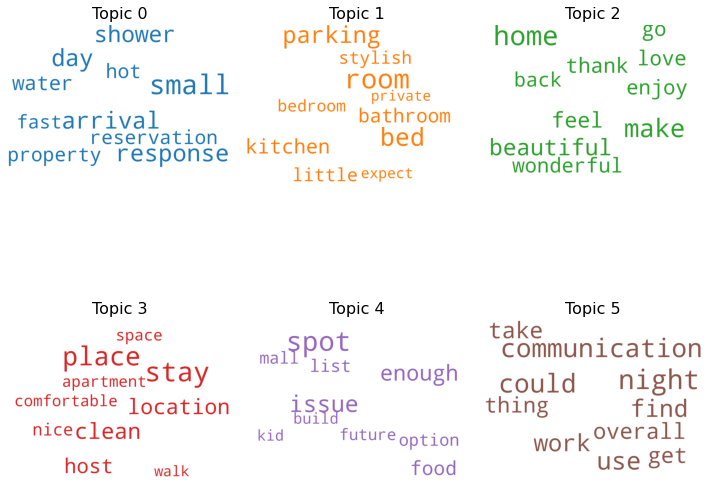

In [59]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Topic 0 - Host interaction 

Topic 1 - Airbnb apartment

Topic 2 - Experince

Topic 3 - Location

Topic 4 - Nearby locations 

Topic 5 - Getting to AirBnB

### Sentiment Analysis

In [47]:
sid = SentimentIntensityAnalyzer()
for sentence in df_review['comments'].values[:5]:
    print (sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
            print ('{0}: {1}, '.format(k, ss[k]))
    print()


The stay at Amos' condo greatly exceeded my expectations. This is a great location that is a short walk from two metro stations and is surrounded by business offices, other condos, and restaurants. 

Very clean and neat accommodations. Bed was a small cot style bed with a foam mattress that was adequate. I had exclusive use of a bathroom with a shower including space to keep my shower supplies. 

Amos went above and beyond to make me feel welcome in his home. Not only did he pick me up from the airport, but he dropped me off when my stay was finished. I highly recommend that anyone planning a trip to DC stay with Amos. You won't regret it!

Amos had stocked the kitchen with plenty to eat for breakfast and access to all appliances if I chose to cook. 
compound: 0.9367, 
neg: 0.0, 
neu: 0.869, 
pos: 0.131, 

What can I say?  AJ picked me up from Dulles, waiting patiently for three hours while I cleared customs and immigration.  "Why did you wait so long?  You could have gone back home." 

In [94]:
df_review['neg']=0.0
df_review['pos']=0.0
df_review['neu']=0.0
df_review['compound']=0.0

for index,row in df_review.iterrows():
    ss = sid.polarity_scores(row['comments'])
    df_review.at[index, 'neg'] = ss['neg']
    df_review.at[index, 'pos'] = ss['pos']
    df_review.at[index, 'neu'] = ss['neu']
    df_review.at[index, 'compound'] = ss['compound']
    
df_review.to_csv('../0_Data/sentiment_review.csv')
            

In [62]:
df_review = pd.read_csv("../0_Data/sentiment_review.csv", encoding='utf-8')

In [63]:
df_review['language']= ""

def detect_lang(sente):
    sente=str(sente)
    try:
        return detect(sente)
    except:
        return "None"

for index,row in df_review.iterrows():
    lang = detect_lang(row['comments'])
    df_review.at[index, 'language'] = lang
    
#taking rows whose language is English
df_en_review=df_review[df_review.language=='en']

df_en_review.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,neg,pos,neu,compound,language
0,0,3344,2185,2009-05-09,12016,Tony,The stay at Amos' condo greatly exceeded my ex...,0.000,0.131,0.869,0.9367,en
1,1,3344,18774,2009-11-29,40724,Faris,"What can I say? AJ picked me up from Dulles, ...",0.006,0.160,0.834,0.9922,en
2,2,3344,20550,2009-12-16,58506,Sean,Amos is a phenomenal host. Where to start? Fir...,0.000,0.190,0.810,0.9902,en
3,3,3344,293978,2011-06-01,583926,Yewwee,Aj is a great and friendly host! Excellent loc...,0.000,0.512,0.488,0.9635,en
4,4,3344,296775,2011-06-04,503189,Jonathan,"As a first-time airbnb.com user, I am glad Amo...",0.000,0.388,0.612,0.9831,en


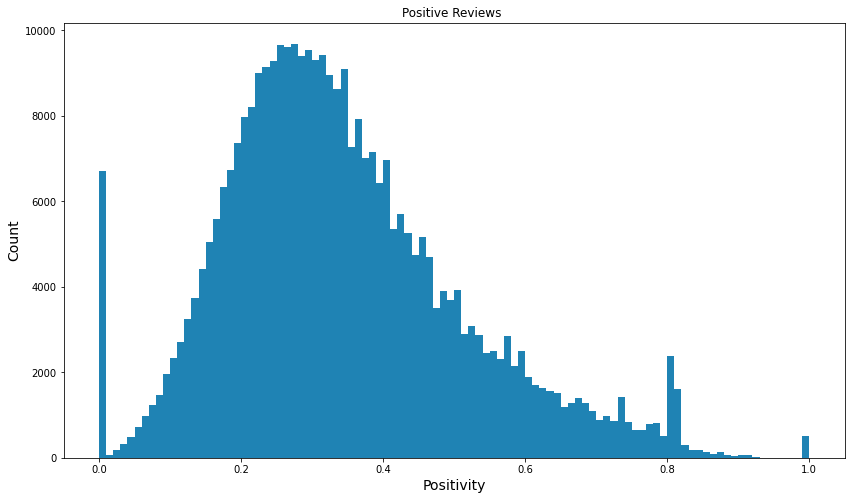

In [82]:
# First lets take a deeper look at Positive 

plt.figure(figsize=(14, 8))

## distribution of price
plt.hist(df_en_review['pos'], bins = 100, color = '#1F83B4')
plt.title('Positive Reviews ')
plt.xlabel('Positivity', fontdict={'fontsize': 14})
plt.ylabel('Count', fontdict={'fontsize': 14});

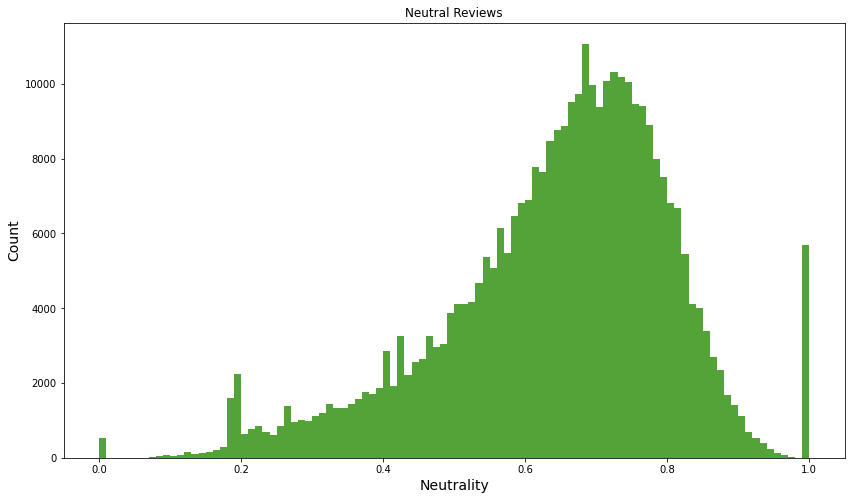

In [83]:
# First lets take a deeper look at neutral 

plt.figure(figsize=(14, 8))

## distribution of price
plt.hist(df_en_review['neu'], bins = 100, color = '#54A338')
plt.title('Neutral Reviews')
plt.xlabel('Neutrality', fontdict={'fontsize': 14})
plt.ylabel('Count', fontdict={'fontsize': 14});

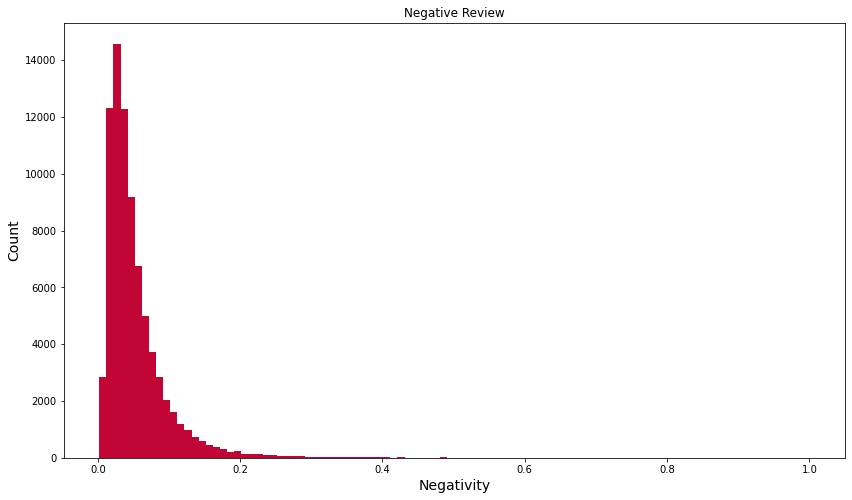

In [84]:
# First lets take a deeper look at negative 

plt.figure(figsize=(14, 8))

## distribution of price
plt.hist(df_en_review[df_en_review['neg'] >0]['neg'], bins = 100, color = '#c10534')
plt.title('Negative Review')
plt.xlabel('Negativity', fontdict={'fontsize': 14})
plt.ylabel('Count', fontdict={'fontsize': 14});

From the above, we can observe that majority of the reviews are perceived as neutral reviews with slight positivity, and not a lot of negative reviews. Thus there is not much really learnt from looking at the just the sentiments 

Improvement - Currently using quite rudementary sentiment classifier --> as there is no pre label airbnb data, what we can try to attempt is to use transfer learning instead.

